In [1]:
from pandas import read_csv
from matplotlib import pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np

# Load data

In [2]:
filename = 'creditcard.csv'
df = read_csv(filename)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Histograms for each feature

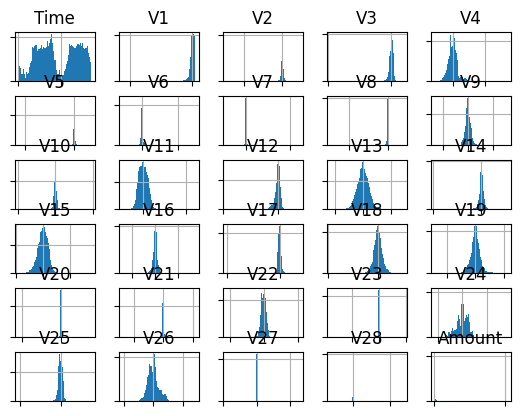

In [3]:
df1 = df.drop('Class', axis=1)
ax = df1.hist(bins=100)
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
plt.show()

# Class count histogram

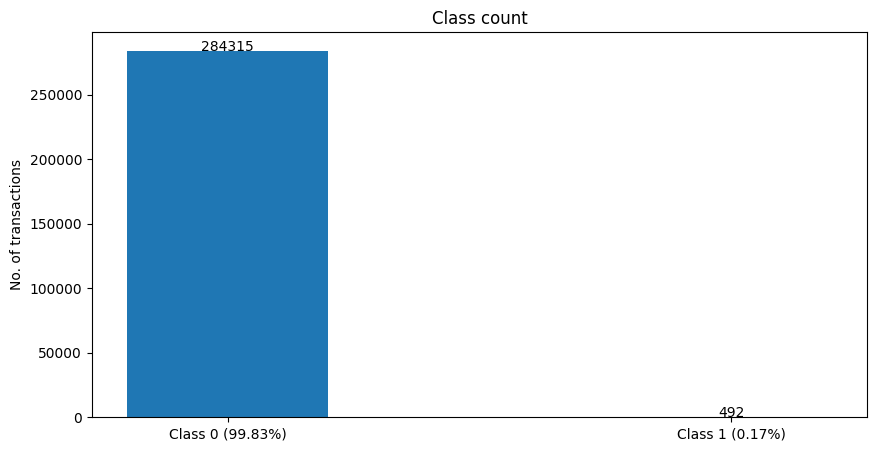

In [4]:
df2 = df['Class']
a = len(df.loc[df['Class'] == 0])
b = len(df.loc[df['Class'] == 1])
c = len(df2)
x = ['Class 0 (' + str(round(a / c * 100, 2)) + '%)', 'Class 1 (' + str(round(b / c * 100, 2)) + '%)']
y = [a, b]
fig = plt.figure(figsize = (10, 5))
plt.bar(x, y, width = 0.4)
plt.ylabel("No. of transactions")
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.title("Class count")
plt.show()

# Custom dataset class

In [5]:
class TransactionDataset(Dataset):

    def __init__(self, inputs, outputs, transform=None, target_transform=None):
        self.transactions = inputs
        self.labels = outputs

    def __len__(self):
        return len(self.transactions)

    def __getitem__(self, idx):
        transaction = self.transactions[idx]
        label = self.labels[idx]
        return transaction, label

In [6]:
path = "creditcard.csv"
data = read_csv(path)

X = data.drop('Class', axis=1)
y = data['Class']

# Train test split

In [7]:
train_mark = int(0.8 * len(X))

X, y = torch.tensor(X.to_numpy()).float(), torch.tensor(y.to_numpy()).float().unsqueeze(-1)

X_train, y_train = X[:train_mark], y[:train_mark]
X_test, y_test = X[train_mark:], y[train_mark:]

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

X_train: torch.Size([227845, 30]), y_train: torch.Size([227845, 1])
X_test: torch.Size([56962, 30]), y_test: torch.Size([56962, 1])


# Creating train test datasets

In [8]:
trainset = TransactionDataset(inputs=X_train, outputs=y_train)
testset = TransactionDataset(inputs=X_test, outputs=y_test)

batch_size = 100

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Creating model

In [9]:
model = torch.nn.Sequential(
            torch.nn.Linear(30, 60),
            torch.nn.ReLU(),
            torch.nn.Linear(60, 30),
            torch.nn.ReLU(),
            torch.nn.Linear(30, 1),
            torch.nn.Sigmoid()
)

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

writer = SummaryWriter('logs')

# Model training

In [10]:
epochs = 2
train_per_epoch = int(len(trainset) / batch_size)

for e in range(epochs):
            
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=True)

    for idx, (transactions, labels) in loop:

        optimizer.zero_grad()
        output = model(transactions)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        writer.add_scalar('loss', loss.item(), (e * train_per_epoch) + idx)
        accuracy = (output.round() == labels).float().mean()
        accuracy = float(accuracy)
        loop.set_description(f"Epoch [{e}/{epochs}")
        loop.set_postfix(loss=loss.item(), acc=accuracy)
        writer.add_scalar('acc', accuracy, (e * train_per_epoch) + idx)

  0%|          | 0/2279 [00:00<?, ?it/s]

Epoch [1/2: 100%|██████████| 2279/2279 [00:07<00:00, 318.08it/s, acc=1, loss=0]       


# Saving model

In [11]:
torch.save(model, 'models/model.pth')

# Evaluating model

In [12]:
model.eval()
false_positives = 0
false_negatives = 0
num_correct = 0
num_samples = 0
loss_cummulative = 0

with torch.no_grad():
                
    for transactions, labels in test_loader:
                                
        output = model(transactions)
        loss = loss_fn(output, labels)
        loss_cummulative += loss.item()
        num_correct += (output.round() == labels).sum()
        num_samples += output.size(0)

        for y_pred, y_true in zip(output, labels):
            if (y_pred.round() == torch.Tensor([1.])) and (y_true == torch.Tensor([0.])):
                false_positives += 1
            elif (y_pred.round() == torch.Tensor([0.])) and (y_true == torch.Tensor([1.])):
                false_negatives += 1

print(f'Correct: {num_correct}, samples: {num_samples}, accuracy: {float(num_correct) / float(num_samples) * 100:.2f}%, false positives: {false_positives}, false negatives: {false_negatives}, loss: {loss_cummulative / len(test_loader)}')

Correct: 56887, samples: 56962, accuracy: 99.87%, false positives: 0, false negatives: 75, loss: 0.13157894736842105


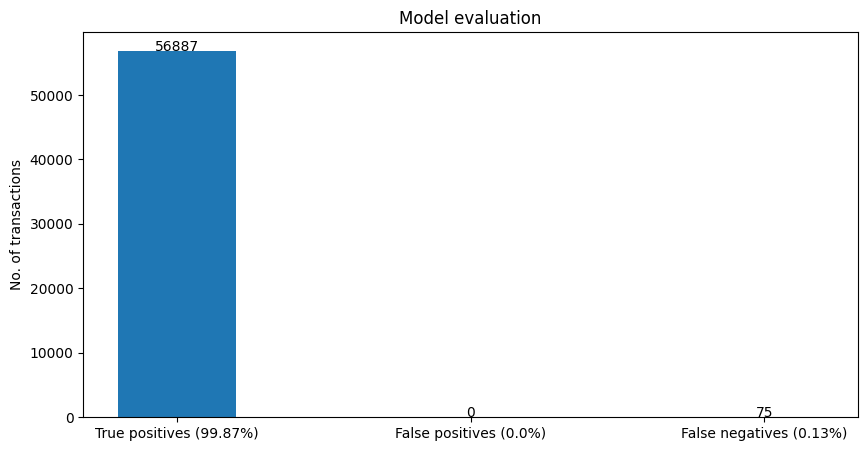

In [13]:
a = round(float(num_correct) / float(num_samples) * 100, 2)
b = round(float(false_positives) / float(num_samples) * 100, 2)
c = round(float(false_negatives) / float(num_samples) * 100, 2)

x = ['True positives (' + str(a) + '%)', 'False positives (' + str(b) + '%)', 'False negatives (' + str(c) + '%)']
y = [int(num_correct), false_positives, false_negatives]

fig = plt.figure(figsize = (10, 5))
plt.bar(x, y, width = 0.4)
plt.ylabel("No. of transactions")
for i in range(len(x)):
    plt.text(i, y[i], y[i], ha = 'center')
plt.title("Model evaluation")
plt.show()